# Location Desirability

*How desirable is each neighborhood?*

The desirability of a location is a strong indicator of which neighborhood is the best because when people choose a place to live, they don't focus on a single metric. Instead, they will focus on a combination of things such as crime rate, school rankings, accessibility to amenities including walking scores and public transportation, whether there are any parks nearby, community facilities and events, taxes, and any return on investment values. 

There are multiple metrics that we could use to determine how desirable a specific neighborhood may be. The first that came to mind was housing prices. An increase in housing prices would indicate there's a higher demand to live in a specific neighborhood, and a large increase would indicate there's a shortage of supply. However, the WPA Regional Data Center had no information about house prices on file. 

Another way we can determine how desirable a specific location might be is to compare population shifts over time. There were a few different data sets available that recorded different things about the way the population has shifted through Allegheny County, so I chose to focus on this metric.

## *-*Round 1*-*

DataSET1 retrieved from: https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-miscellaneous-data/resource/82f29015-6905-4b1c-8300-afe9bb2231b3
DataSET2 retrieved from: https://data.wprdc.org/dataset/1984-community-profiles-a-descriptive-picture-of-communities-in-allegheny-county/resource/8e2b239e-4a46-49f9-bd13-2566f3c64d28

### Pittsburgh American Community Survey 2015 - miscellaneous-data -
*Organization: Census Bureau's Population Estimates Program*

Pros: 
- Updated in 2017
- Simple to understand/read

Cons:
- Estimated Population
- Only includes neighborhoods within the city limits

### 1984 Community Profiles - A Descriptive Picture of Communities in Allegheny County - 
*Organization: University of Pittsburgh Library System - Erica Short (student-employee)*

Pros:
- Includes all neighborhoods within AC limits.
- Simple to understand/read

Cons:
- Census data is from 1984

### Considerations -

While the data from 2017 only includes neighborhoods within the city limits, we can combine both sets of data using 1984 as a starting point to determine which city neighborhoods, if any, experienced growth from 1984 - 2017. 

### ---Step 1 : Combine data sets -



In [32]:
import pandas as pd
import numpy as np

# load data from a downloaded data set
pop2017 = pd.read_csv("2017pop.csv") 
pop1984 = pd.read_csv("1984pop.csv") 


# extract relevant data
pop2017SEL = pop2017.iloc[:,[0,2]] 
pop2017SEL.columns = {'Neighborhood', 'y2017'} # pop2017SEL is the 2017 dataset 

# extract relevant data
pop1984SEL = pop1984.iloc[:, [0,1]]
pop1984SEL.columns = {'Neighborhood', 'y1984'} # pop1984SEL is the 1984 dataset

# 1984 set uses commas, eliminate them for comparable input
pop1984SEL = pop1984SEL.replace(',', '', regex=True)


# combine sets of data
# pop1984SEL (Neighborhood, 1984)
# pop2017SEL (Neighborhood, 2017)
combinedSET = pd.merge(pop1984SEL, pop2017SEL)
combinedSET.head()


,Neighborhood,y1984,y2017
0,Allegheny Center,1554,1411
1,Allegheny West,845,343
2,Allentown,4043,2558
3,Arlington,2764,1852
4,Arlington Heights,1438,272


### --- Step 2 : Do the math -

The primary goal is to find the neighborhood with the highest population growth. However, it's important to note that the population in Allgheny County decreased by 13.2% between the years of 1984 and 2017. This could be due to any number of reasons such as decline in industry pushing people to relocate or the increased accessibility to other counties with lower tax rates. Because it's unlikely that an entire neighborhood would all move out of the county at the same time, it's relatively safe to use this 13.2% as a rough average to determine whether people moved away from an area because 13.2% of the population moved out of AC, or if they moved away from an area at a higher rate, indicating lower desirability. 

In [35]:
# subtract 1984 pop from 2017 pop 
# must be converted to float
combinedSET['Change'] = combinedSET['y2017'].astype(float) - combinedSET['y1984'].astype(float)

# allows the entire list to be shown by call to print()
pd.set_option('display.max_rows', None)

# For each of these neighborhoods, we can expect a decrease of 13.2%, but any higher of a 
# decrease would mean these neighborhoods rate very low on the desirability scale.
# Let's find those percentages:

combinedSET['perc'] = combinedSET['Change'].astype(float) / combinedSET['y1984'].astype(float)
combinedSET = combinedSET.sort_values(by='perc', ascending = False)
combinedSET.head()


,Neighborhood,y1984,y2017,Change,perc
73,Strip District,435,747,312.0,0.717241
10,Bluff,4504,6294,1790.0,0.397425
16,Central Business District,3220,4060,840.0,0.260870
77,Troy Hill,1820,2283,463.0,0.254396
50,North Oakland,8708,9602,894.0,0.102664


### --- Step 3 : Reintroduce lost data - 

This combinedSET now reflects the neighborhoods closest to the city limits which have experienced the largest growth in population beyond average county losses of 13.2%. However, we've only eliminated the least desirable that are in *both* data sets. Because there were so many city neighborhoods that experienced a loss well beyond 13.2%, previous residents of those neighborhoods had to have moved somewhere, either to one of the neighborhoods that experienced growth, or a neighborhood that wasn't in the 2017 data set.

The final set of data in round 1 should include every neighborhood which hasn't been eliminated through population decline.

In [36]:
contenderList = pd.merge(pop1984SEL, pop2017SEL, how="left") # merge original 2 sets of data
contenderList = contenderList[contenderList['y2017'].isnull()] # only include neighborhoods which aren't represented in the 2017 set
contenderList = contenderList[contenderList.Neighborhood != 'Allegheny County'] # take out large cumulative sums
contenderList = contenderList[contenderList.Neighborhood != 'Pittsburgh']
contenderList = contenderList[contenderList.Neighborhood != 'Pittsburgh SMSA']
contenderList.head()

,Neighborhood,y1984,y2017
0,Aleppo,1134,NaN
7,Aspinwall,3284,NaN
8,Avalon,6240,NaN
9,Baldwin Borough,24598,NaN
10,Baldwin Township,2680,NaN


### --- Final Step : Combine lost data + city data - 

In [37]:
combinedSET = combinedSET.iloc[:,[0,1]] 
contenderList = contenderList.iloc[:,[0,1]] 

contenderList = contenderList.append(combinedSET)
contenderList = contenderList.sort_values(by='Neighborhood')

contenderList.reset_index(inplace = True, drop = True)

contenderList.head() # contenderList is now a list of the suburbs + any "city" location that experienced a growth in population
                     # we only have 142 potential neighborhoods rather than 218
    
# contenderList.to_csv('contenderList.csv')

,Neighborhood,y1984
0,Aleppo,1134
1,Allegheny Center,1554
2,Allegheny West,845
3,Allentown,4043
4,Arlington,2764


### Conclusion - 

I was able to remove half of the candidates of neighborhoods which experienced the highest population growth, but all that really did was highlight that very few city neighborhoods experienced *any* growth. It would have been nice if the neighborhoods matched in both sets of data to reflect growth/decline over a large time period of time. It's interesting to note that the rate of decline across all of the neighborhoods, even with consideration to the overall decline of 13.2% exceeds the growth of those neighborhoods which have been documented. This would indicate that a large amount of people are moving out of the neighborhoods closer to the city, with a few exceptions, and towards neighborhoods father into the suburbs, but still in Allegheny County.

![](contenderListout.png)

## - Round 2 -

DataSET3 retrieved from: https://data.wprdc.org/dataset/f7ccd6d1-b38e-4b08-aba1-b78b4e9483ca/resource/bcb6d6a8-8d32-4abb-a377-77d7358d94c2/download/pa_allegheny_42003.csv

### Allegheny County 2000/2010 Census Tract Relationships
*Organization : University of Pittsburgh*

Pros:
- Exists
- Spans 10 years in which indulgence was a key factor

Cons:
- Only spans 10 years (including 9/11, the dot com bubble burst and the mortgage crisis)
- Changes depending on census recommendations of neighborhood populations
- Key is only available on a mapped image(it's difficult to compare to other sets of data which may be organized differently)
- Difficult to read
- No identifying information.

### Considerations - 

This data set is limited and really only reflects movement in relation to an extremely volatile market. Because so many people were taking advantage of cheap credit in the 00s until the mortgage crisis, it's likely that cost itself was less of a factor, and that people instead indulged in moving to areas that were slightly outside of their budget. 

### --- Step 1 : Extract data & do the math -

In [44]:
# only extract certain columns
tractDATA = pd.read_csv("tractdata.csv")
tractDATA = tractDATA.iloc[:,[3, 5, 12, 14]] 

# new column  = change in population
tractDATA['Change'] = tractDATA['POP10'].astype(float) - tractDATA['POP00'].astype(float)

# remove tracts which haven't changed, or have declined in population
tractDATA = tractDATA[tractDATA['Change'] > 0]

# there were a few duplicates which only differed in columns that aren't important to 
# our goal -
tractDATA = tractDATA.drop_duplicates(subset=['POP10'], keep='first')

# sort by highest population
tractDATA = tractDATA.sort_values(by='POP10', ascending = False)

tractDATA.reset_index(inplace = True, drop = True)

tractDATA.head(18)

,TRACT00,POP00,TRACT10,POP10,Change
0,408001,4782,409000,11497,6715.0
1,411000,6938,412001,8605,1667.0
2,401100,4467,912700,7307,2840.0
3,450700,3132,451300,7133,4001.0
4,456001,3511,458000,7080,3569.0
5,408002,6325,414102,7040,715.0
6,459201,5780,453004,6955,1175.0
7,410000,1156,411000,6915,5759.0
8,419000,2962,526101,6902,3940.0
9,40900,2969,10300,6600,3631.0


### --- Step 2 : Sort by 10 year population growth -

If the rate of change is more important:

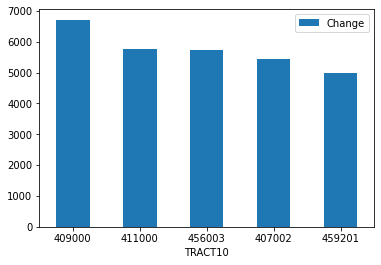

In [51]:
tractDATA = tractDATA.sort_values(by='Change', ascending = False)

tractDATA1 = tractDATA.head(5)
plot1 = tractDATA1.plot.bar(x='TRACT10', y='Change', rot=0)

### --- Step 3: Sort by highest population in 2010 - 

If the population size itself is the most important metric:

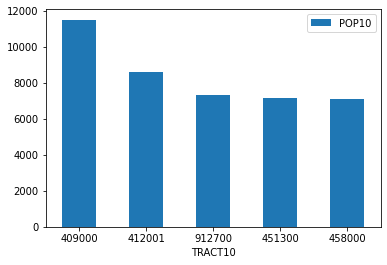

In [52]:
tractDATApop = tractDATA.sort_values(by='POP10', ascending = False)

tractDATA1pop = tractDATApop.head(5)
plot2 = tractDATA1pop.plot.bar(x='TRACT10', y='POP10', rot=0)

### Conclusion : 

Considering that the lowest population increase is nearly 90% of the total population in 2010 of the highest populated neighborhoods, I'd consider this to be the better metric to determine neighborhood desirability.
The TRACT10 numerical values correspond to the following neighborhoods:

- 1 = Pine Township +6715
- 2 = Marshall Township +5759
- 3 = South Fayette +5718
- 4 = S. West Deer +5430
- 5 = S. Robinson Township +4986

Pine Township has the greatest increase in population from 2000 - 2010.

![](popincrease.png)